In [7]:
import torch
import torchvision
import torch.nn as nn
from torch.utils.data import Dataset

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

## Compose的使用

Compose可以将多个预处理的方法进行打包. 当有数据来的时候, 一次性完成所有的预处理动作.

In [4]:
class ToTensor:
    # 将Numpy转换为tensor格式
    def __call__(self, X):
        return torch.from_numpy(X)

class AddMulTransform:
    def __call__(self, X):
        X = torch.tensor([1]) + 2*X
        return X

In [5]:
# 定义预处理集合器
composed = torchvision.transforms.Compose([ToTensor(), AddMulTransform()])
composed

Compose(
)

In [6]:
# 进行数据的测试
data = np.array([[1, 2, 3], [3,4,5]])
composed(data)

tensor([[ 3,  5,  7],
        [ 7,  9, 11]])

## 与Dataset结合使用


In [64]:
class TestDataset(Dataset):
    # 需要继承dataset数据集
    def __init__(self, transform):
        # I初始化数据
        xy = np.random.random((100, 13))*100
        self.n_samples = xy.shape[0] # 样本的个数

        # 这里我们就不做Tensor的转换了，将其全部放入 transform 中
        self.x_data = xy[:, 1:]
        self.y_data = xy[:, 0].reshape(-1,1)
        # 数据预处理集合
        self.transform = transform

    # 返回 dataset[index]
    def __getitem__(self, index):
        sample = self.x_data[index], self.y_data[index]

        if self.transform:
            # 数据预处理在这里(只对x进行预处理)
            sample = self.transform(sample)
        
        return sample
    
    def __len__(self):
        # 返回数据长度
        return self.n_samples

In [65]:
# 定义归一化操作
class Normalization:
    """这里是只对features进行归一化处理
    """
    def __call__(self, sample):
        inputs, targets = sample
        amin, amax = inputs.min(), inputs.max()  # 求最大最小值
        inputs = (inputs-amin)/(amax-amin)  # (矩阵元素-最小值)/(最大值-最小值)
        return inputs, targets

# 定义numpy转tensor
class ToTensor:
    def __call__(self, sample):
        inputs, targets = sample
        return torch.from_numpy(inputs), torch.from_numpy(targets)

In [66]:
# 定义 composed
composed = torchvision.transforms.Compose([Normalization(), ToTensor()])

# 初始化dataset的时候传入transform即可
dataset = TestDataset(transform=composed)

In [67]:
features_0, labels_0 = dataset[0]
print(type(features_0), type(labels_0))

<class 'torch.Tensor'> <class 'torch.Tensor'>


In [68]:
print(features_0) # 这里是进行归一化的结果
print(labels_0) # 这里是没有进行归一化的结果

tensor([0.0935, 0.2159, 0.9332, 0.0000, 0.0356, 0.3848, 0.4804, 0.0839, 0.1280,
        0.7919, 0.6031, 1.0000], dtype=torch.float64)
tensor([44.6151], dtype=torch.float64)


## 图像预处理

In [69]:
# 我们下载测试数据
!wget -nc "https://img.mathpretty.com/20200804_141727_tnzpt18.jpg"

--2020-08-04 12:17:50--  https://img.mathpretty.com/20200804_141727_tnzpt18.jpg
Resolving img.mathpretty.com (img.mathpretty.com)... 185.232.59.135
Connecting to img.mathpretty.com (img.mathpretty.com)|185.232.59.135|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 21006 (21K) [image/jpeg]
Saving to: ‘20200804_141727_tnzpt18.jpg’

20200804_141727_tnz 100%[===================>]  20.51K  --.-KB/s    in 0.001s  

2020-08-04 12:17:52 (14.4 MB/s) - ‘20200804_141727_tnzpt18.jpg’ saved [21006/21006]



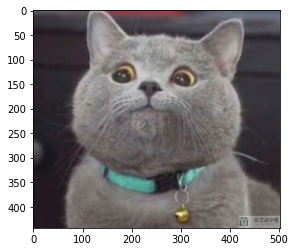

In [71]:
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
%matplotlib inline
img = Image.open("20200804_141727_tnzpt18.jpg")
imshow(img)

### 图像大小的剪裁

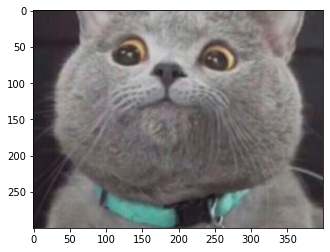

In [74]:
# torchvision.transforms.CenterCrop（size）：从中心开始，裁剪给定大小的 PIL 图像
transform = transforms.CenterCrop((300, 400))
new_img = transform(img)
imshow(new_img)

### 改变图片的亮度、对比度和饱和度

使用`transforms.ColorJitter`来完成改变

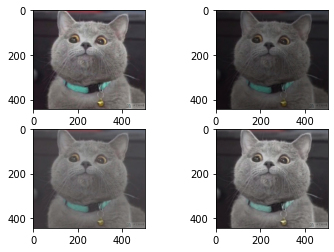

In [75]:
# transforms.ColorJitter(brightness=0, contrast=0, saturation=0, hue=0)：
# 改变图片的亮度、对比度和饱和度

plt.subplot(221)
imshow(img) # 显示原始图片

# r随机改变亮度
my_img1 = transforms.ColorJitter((0.5, 0.6))(img)
plt.subplot(222)
imshow(my_img1)

# 随机改变对比度
my_img2 = transforms.ColorJitter(0, (0.5, 0.6))(img)
plt.subplot(223)
imshow(my_img2)

# 随机改变饱和度
my_img3 = transforms.ColorJitter(0, 0, (0.5, 0.6))(img)
plt.subplot(224)
imshow(my_img3)

plt.show()

### 将图像转为灰度图

使用torchvision.transforms.Grayscale(num_output_channels)将图像转换为灰度图.

- 如果返回的图像是单通道num_output_channels=1
- 如果返回的图像是3通道，其中num_output_channels=3, 且 r == g == b

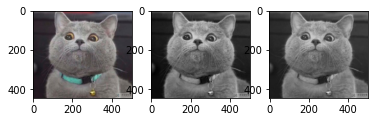

In [76]:
plt.subplot(131)
imshow(img) # 显示原始图片
my_img1 = transforms.Grayscale(1)(img)
plt.subplot(132)
imshow(my_img1, 'gray') 
my_img2 = transforms.Grayscale(3)(img)
plt.subplot(133)
imshow(my_img2)

### 图像的填充

使用pad对图像进行填充

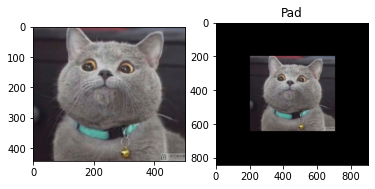

In [78]:
# transforms.Pad（padding，fill = 0，padding_mode ='constant' ）：
# 使用给定的 pad 值将给定的 PIL 图像四处填充
plt.subplot(121)
imshow(img)

# 四周加黑色的边界
my_img = transforms.Pad(padding=200, fill=(0, 0, 0), padding_mode='constant')(img)
plt.subplot(122).set_title("Pad")
imshow(my_img)

### 中心仿射变换

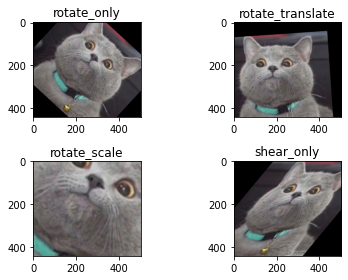

In [79]:
# transforms.RandomAffine(degrees, translate=None, scale=None,
#                       shear=None, resample=False, fillcolor=0)：
# 保持图像中心不变的中心仿射变换(可以理解为不同程度的旋转，再在空余位置补 0)
my_img1 = transforms.RandomAffine(60)(img)
plt.subplot(221).set_title("rotate_only")
imshow(my_img1)
my_img2 = transforms.RandomAffine(60, translate=(0.3, 0.3))(img)
plt.subplot(222).set_title("rotate_translate")
imshow(my_img2)
my_img3 = transforms.RandomAffine(60, scale=(2.0, 2.1))(img)
plt.subplot(223).set_title("rotate_scale")
imshow(my_img3)
my_img4 = transforms.RandomAffine(0, shear=60)(img)
plt.subplot(224).set_title("shear_only")
imshow(my_img4)
plt.tight_layout()

### 图像的随机剪裁

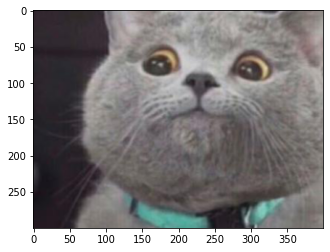

In [81]:
#torchvision.transforms.RandomResizedCrop(size, scale,ratio,interpolation)
new_img = transforms.RandomResizedCrop((300, 400), scale=(0.08, 1.0), ratio=(0.75, 1.333333333), interpolation=2)(img)
imshow(new_img)